# Part 1: Feature Extraction

## Install and import libraries

In [ ]:
!pip install yfinance matplotlib seaborn scikit-learn
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 1. Load dataset (Tech stock returns)

In [ ]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "META"]
data = yf.download(tickers, start="2015-01-01", end="2025-01-01")
prices = data["Close"]

/tmp/ipython-input-1571966358.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  5 of 5 completed


## 2. Compute returns

In [ ]:
returns = prices.pct_change().dropna()


## 3. Standardize data

In [ ]:
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns)

## 4. Apply PCA

In [ ]:
pca = PCA()
pca.fit(scaled_returns)
explained_variance = pca.explained_variance_ratio_

## 5. Plot cumulative variance explained

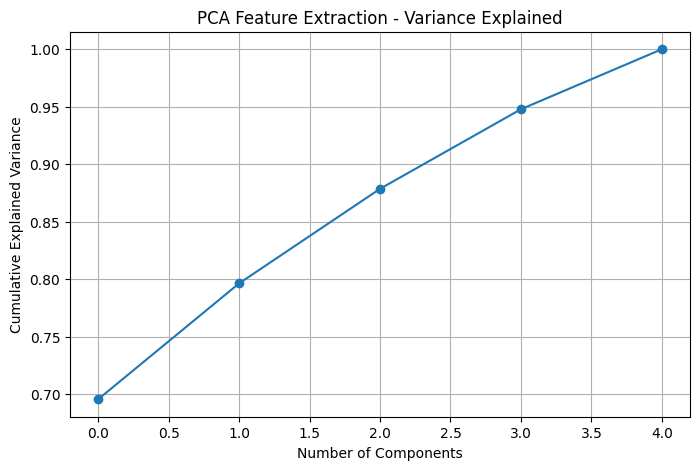

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Feature Extraction - Variance Explained")
plt.grid(True)
plt.show()

## 6. Transform into first 3 components


In [ ]:
pca_returns = pca.transform(scaled_returns)[:, :3]
pca_df = pd.DataFrame(pca_returns, index=returns.index, columns=["PC1","PC2","PC3"])
pca_df.head()

,PC1,PC2,PC3
Date,,,
2015-01-05,-2.326907,-0.431034,0.118491
2015-01-06,-1.860659,0.496368,-0.685084
2015-01-07,0.743403,0.602636,0.137853
2015-01-08,2.315672,1.084683,-1.013094
2015-01-09,-1.020936,0.244191,-0.424693


# Part 2: Non-Stationarity & Equilibrium

## Install and import libraries


In [ ]:
!pip install yfinance statsmodels matplotlib seaborn
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

## 1. Load dataset ( Oil vs S&P500)


In [ ]:
oil = yf.download("CL=F", start="2010-01-01", end="2025-01-01", auto_adjust=False)["Close"]
sp500 = yf.download("^GSPC", start="2010-01-01", end="2025-01-01", auto_adjust=False)["Close"]
df = pd.merge(oil, sp500, left_index=True, right_index=True, how='inner').dropna()
df.columns = ["Oil", "S&P500"]

/tmp/ipython-input-3672462112.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oil = yf.download("CL=F", start="2010-01-01", end="2025-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3672462112.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2010-01-01", end="2025-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed


## 2. Augmented Dickey-Fuller test


In [ ]:
def adf_test(series, name=""):
    result = adfuller(series)
    print(f"ADF Test for {name}")
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")
    print()

adf_test(df["Oil"], "Oil Prices")
adf_test(df["S&P500"], "S&P 500")

ADF Test for Oil Prices
ADF Statistic: -2.185
p-value: 0.212
Non-Stationary

ADF Test for S&P 500
ADF Statistic: 1.375
p-value: 0.997
Non-Stationary



## 3. Cointegration tests


In [ ]:
score, pvalue, _ = coint(df["Oil"], df["S&P500"])
print(f"Engle-Granger cointegration p-value: {pvalue}")

johansen_test = coint_johansen(df, det_order=0, k_ar_diff=1)
print("Johansen Test Eigenvalues:", johansen_test.eig)

Engle-Granger cointegration p-value: 0.4206928054560968
Johansen Test Eigenvalues: [2.03740406e-03 9.15874775e-05]


## 4. Estimate long-run equilibrium (regression)


In [ ]:
X = sm.add_constant(df["S&P500"])
model = sm.OLS(df["Oil"], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Oil   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     61.89
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           4.72e-15
Time:                        08:20:09   Log-Likelihood:                -16868.
No. Observations:                3772   AIC:                         3.374e+04
Df Residuals:                    3770   BIC:                         3.375e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.8506      0.820     94.933      0.0

## 5. Get residuals (error correction term)


In [ ]:
df["residuals"] = model.resid
df["Oil_diff"] = df["Oil"].diff()
df["SP_diff"] = df["S&P500"].diff()
df["residuals_lag"] = df["residuals"].shift()

## 6. Build Error Correction Model


In [ ]:
ecm = sm.OLS(
    df["Oil_diff"].dropna(),
    sm.add_constant(df[["residuals_lag","SP_diff"]].dropna())
).fit()
print(ecm.summary())

                            OLS Regression Results                            
Dep. Variable:               Oil_diff   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     50.91
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           1.53e-22
Time:                        08:20:23   Log-Likelihood:                -7843.4
No. Observations:                3771   AIC:                         1.569e+04
Df Residuals:                    3768   BIC:                         1.571e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0148      0.032     -0.469

## 7. Plots


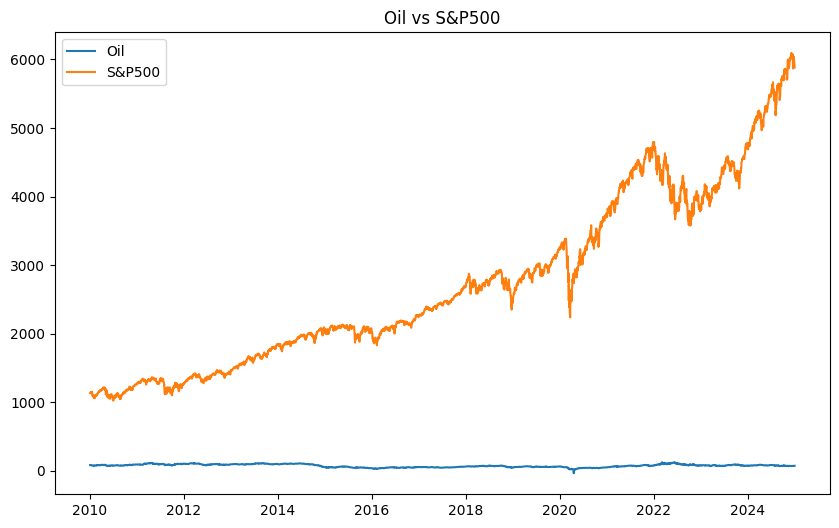

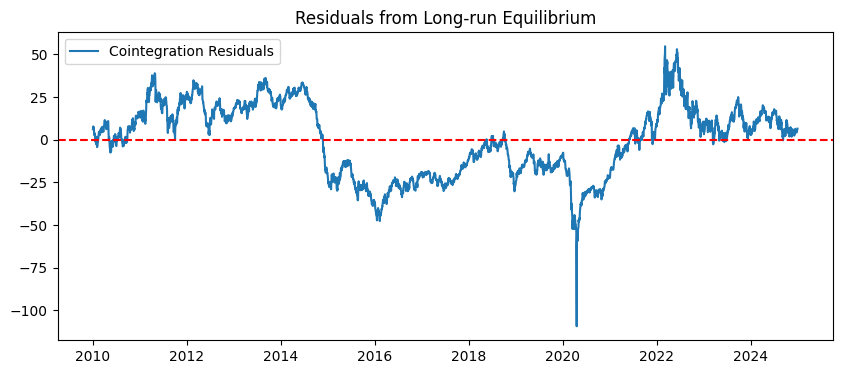

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df["Oil"], label="Oil")
plt.plot(df["S&P500"], label="S&P500")
plt.legend()
plt.title("Oil vs S&P500")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["residuals"], label="Cointegration Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.legend()
plt.title("Residuals from Long-run Equilibrium")
plt.show()